<a href="https://colab.research.google.com/github/Jeru-John/ML-case-studies/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports and warehouse data:**

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
from google.colab import data_table
import folium
from IPython.display import HTML
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering, SpectralClustering

In [57]:
!pip install --upgrade plotly
import plotly.graph_objects as go


!pip install --upgrade kneed
from kneed import KneeLocator

In [58]:
data = pd.read_csv('/content/bank_transactions.csv')
print(data.shape)
data_table.DataTable(data, include_index=False, num_rows_per_page=10)

(1048567, 9)


In [59]:
# Explore final shape and size.
row, column = data.shape
print('The dataset contains', row, 'rows and', column, 'columns')

The dataset contains 1048567 rows and 9 columns


Defining a `check` function below to get the insights of the data here and there to reuse it.

In [60]:
# Show detailes of the data set
def check(df):
    l=[]
    columns=df.columns
    for col in columns:
        dtypes=df[col].dtypes
        nunique=df[col].nunique()
        sum_null=df[col].isnull().sum()
        l.append([col,dtypes,nunique,sum_null])
    df_check=pd.DataFrame(l)
    df_check.columns=['column','dtypes','nunique','sum_null']
    return df_check
data_table.disable_dataframe_formatter()
check(data)

column   dtypes  nunique  sum_null
0            TransactionID   object  1048567         0
1               CustomerID   object   884265         0
2              CustomerDOB   object    17254      3397
3               CustGender   object        3      1100
4             CustLocation   object     9355       151
5       CustAccountBalance  float64   161328      2369
6          TransactionDate   object       55         0
7          TransactionTime    int64    81918         0
8  TransactionAmount (INR)  float64    93024         0

In [61]:
data.shape

(1048567, 9)

# **Data cleansing:**

From the previous table we infer that there are missing values(ie, null values) in *CustomerDOB, CustGender, CustLocation and CustAccountBalance*.

**IMPUTING:**

Hence doing data cleansing by
Handling missing values in
1. CustomerDOB --> imputing with mode
2. CustGender ---> imputing with mode
3. CustLocation -> imputing with mode
4. CustAccountBalance --> imputing with median

In [62]:
print(data.shape)
# Handling missing values in 'CustGender and CustLocation' by imputing with the mode
data['CustomerDOB'].fillna(data['CustomerDOB'].mode()[0], inplace=True)
data['CustGender'].fillna(data['CustGender'].mode()[0], inplace=True)
data['CustLocation'].fillna(data['CustLocation'].mode()[0], inplace=True)

# Handling missing values in 'CustAccountBalance' by imputing with the mean
average_accountBalance = data['CustAccountBalance'].mean()
data['CustAccountBalance'].fillna(average_accountBalance, inplace=True)

# Checking the updated data
print(check(data));
print(data.shape)

(1048567, 9)
                    column   dtypes  nunique  sum_null
0            TransactionID   object  1048567         0
1               CustomerID   object   884265         0
2              CustomerDOB   object    17254         0
3               CustGender   object        3         0
4             CustLocation   object     9355         0
5       CustAccountBalance  float64   161329         0
6          TransactionDate   object       55         0
7          TransactionTime    int64    81918         0
8  TransactionAmount (INR)  float64    93024         0
(1048567, 9)


INSIGHT: We infer that there is no null values from the above table.

**Data Type Casting:**

1. Converting CustomerDOB and TransactionDate to their correct datatypes.

Finding out CustomerAge and adding it as a new column in the table:

`CustomerAge = data["TransactionDate"].dt.year - data["CustomerDOB"].dt.year`

data["TransactionDate"].dt.year ---> transaction done year

data["CustomerDOB"].dt.year -------> customer DOB year

In [63]:
# Convert 'CustomerDOB' to datetime
data['CustomerDOB'] = pd.to_datetime(data['CustomerDOB'], errors='coerce')  # 'coerce' will handle any invalid date values
data["TransactionDate"] = pd.to_datetime(data["TransactionDate"], errors='coerce')
data["CustomerAge"] = data["TransactionDate"].dt.year-data["CustomerDOB"].dt.year

print(check(data))

                    column          dtypes  nunique  sum_null
0            TransactionID          object  1048567         0
1               CustomerID          object   884265         0
2              CustomerDOB  datetime64[ns]    17254         0
3               CustGender          object        3         0
4             CustLocation          object     9355         0
5       CustAccountBalance         float64   161329         0
6          TransactionDate  datetime64[ns]       55         0
7          TransactionTime           int64    81918         0
8  TransactionAmount (INR)         float64    93024         0
9              CustomerAge           int64      100         0


**Let us start looking into each column and do data cleaning if needed:**

*CustGender:*

In [64]:
data['CustGender'].value_counts()

M    766630
F    281936
T         1
Name: CustGender, dtype: int64

It seems we have only one Transgender, which would not make much difference in our inference. Hence droping it.

In [65]:
data.drop(data[data['CustGender']=='T'].index,inplace=True)

Infer: Male data seems to be greater than Female data

*CustomerAge:*


In [66]:
min(data["CustomerAge"])

-56

Infer: There are ages below 0 which is impossible. So droping out them.

In [67]:
data.drop(data[data["CustomerAge"]<0].index.tolist(), axis=0, inplace=True)
print(min(data["CustomerAge"]))
print(data.shape)

0
(964250, 10)


In [68]:
data.columns

Index(['TransactionID', 'CustomerID', 'CustomerDOB', 'CustGender',
       'CustLocation', 'CustAccountBalance', 'TransactionDate',
       'TransactionTime', 'TransactionAmount (INR)', 'CustomerAge'],
      dtype='object')

In [69]:
#df['TransactionDate1'] ==> I will keep it to do visaulization
data['TransactionDate1']=data['TransactionDate'] # ==> to calculate the minimum (first transaction)
data['TransactionDate2']=data['TransactionDate'] # ==> to calculate the maximum (last transaction)

In [70]:
data.shape

(964250, 12)

# **RMF strategy application:**

*`RMF_data DataFrame: Aggregating data for each unique customer`*

The RMF strategy is commonly used in marketing and customer relationship management to segment customers based on their behavior. What the RMF table strategy means:

**RMF Table Strategy:**

`Recency (R):` This dimension focuses on how recently a customer has made a purchase or engaged with your business. Customers who have interacted more recently are often considered more engaged.

`Frequency (F):` Frequency refers to how often a customer makes a purchase or engages with your business. Customers who make frequent transactions are typically more valuable.

`Monetary (M):` Monetary represents the monetary value of a customer's transactions. It signifies how much a customer has spent or the revenue generated from their transactions.

In [71]:
#Creating RMF Table Strategy

RMF_data = data.groupby("CustomerID").agg({
                                        "TransactionID" : "count",
                                        "CustGender" : "first",
                                        "CustLocation":"first",
                                        "CustAccountBalance"  : "mean",
                                        "TransactionAmount (INR)" : "mean",
                                        "CustomerAge" : "max",
                                        "TransactionDate2":"max",
                                        "TransactionDate1":"min",
                                        "TransactionDate":"median"
                        })

RMF_data = RMF_data.reset_index()
RMF_data.head()

CustomerID  TransactionID CustGender CustLocation  CustAccountBalance  \
0   C1010011              2          F        NOIDA           76340.635   
1   C1010012              1          M       MUMBAI           24204.490   
2   C1010014              2          F       MUMBAI          100112.950   
3   C1010018              1          F    CHAMPARAN             496.180   
4   C1010028              1          F        DELHI          296828.370   

   TransactionAmount (INR)  CustomerAge TransactionDate2 TransactionDate1  \
0                   2553.0           33       2016-09-26       2016-09-08   
1                   1499.0           22       2016-08-14       2016-08-14   
2                    727.5           32       2016-07-08       2016-01-08   
3                     30.0           26       2016-09-15       2016-09-15   
4                    557.0           28       2016-08-29       2016-08-29   

  TransactionDate  
0      2016-09-17  
1      2016-08-14  
2      2016-04-08  
3      2016-09-15  
4      2016-08-29

In [72]:
data.shape

(964250, 12)

In [73]:
RMF_data.shape

(823685, 10)

In [74]:
RMF_data.drop(columns=["CustomerID"],inplace=True)
RMF_data.shape

(823685, 9)

In [75]:
RMF_data['Recency']=RMF_data['TransactionDate2']-RMF_data['TransactionDate1']
RMF_data['Recency']=RMF_data['Recency'].astype(str)
RMF_data.head()

TransactionID CustGender CustLocation  CustAccountBalance  \
0              2          F        NOIDA           76340.635   
1              1          M       MUMBAI           24204.490   
2              2          F       MUMBAI          100112.950   
3              1          F    CHAMPARAN             496.180   
4              1          F        DELHI          296828.370   

   TransactionAmount (INR)  CustomerAge TransactionDate2 TransactionDate1  \
0                   2553.0           33       2016-09-26       2016-09-08   
1                   1499.0           22       2016-08-14       2016-08-14   
2                    727.5           32       2016-07-08       2016-01-08   
3                     30.0           26       2016-09-15       2016-09-15   
4                    557.0           28       2016-08-29       2016-08-29   

  TransactionDate   Recency  
0      2016-09-17   18 days  
1      2016-08-14    0 days  
2      2016-04-08  182 days  
3      2016-09-15    0 days  
4      2016-08-29    0 days

In [76]:
# Define a function to convert "X days" to integer and replace 0 with 1
def rep_0(value):
    if value == "0 days":
        return 1  # Replace "0 days" with 1
    else:
        # Extract the integer part from the string
        return int(value.split()[0])

# Apply the function to the 'Recency' column
RMF_data['Recency'] = RMF_data['Recency'].apply(rep_0)


In [77]:
RMF_data.head()

TransactionID CustGender CustLocation  CustAccountBalance  \
0              2          F        NOIDA           76340.635   
1              1          M       MUMBAI           24204.490   
2              2          F       MUMBAI          100112.950   
3              1          F    CHAMPARAN             496.180   
4              1          F        DELHI          296828.370   

   TransactionAmount (INR)  CustomerAge TransactionDate2 TransactionDate1  \
0                   2553.0           33       2016-09-26       2016-09-08   
1                   1499.0           22       2016-08-14       2016-08-14   
2                    727.5           32       2016-07-08       2016-01-08   
3                     30.0           26       2016-09-15       2016-09-15   
4                    557.0           28       2016-08-29       2016-08-29   

  TransactionDate  Recency  
0      2016-09-17       18  
1      2016-08-14        1  
2      2016-04-08      182  
3      2016-09-15        1  
4      2016-08-29        1

In [78]:
RMF_data.rename(columns={"TransactionID":"Frequency"},inplace=True)

In [79]:
RMF_data.head(3)

Frequency CustGender CustLocation  CustAccountBalance  \
0          2          F        NOIDA           76340.635   
1          1          M       MUMBAI           24204.490   
2          2          F       MUMBAI          100112.950   

   TransactionAmount (INR)  CustomerAge TransactionDate2 TransactionDate1  \
0                   2553.0           33       2016-09-26       2016-09-08   
1                   1499.0           22       2016-08-14       2016-08-14   
2                    727.5           32       2016-07-08       2016-01-08   

  TransactionDate  Recency  
0      2016-09-17       18  
1      2016-08-14        1  
2      2016-04-08      182

In [80]:
# to claculate the otliers for each feature
lower_list=[]
upper_list=[]
num_list=[]
perc_list=[]
cols=['Frequency', 'CustAccountBalance','TransactionAmount (INR)', 'CustomerAge', 'Recency']
for i in cols:
    Q1 = RMF_data[i].quantile(0.25)
    Q3 = RMF_data[i].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    # calculate number of outliers
    num=RMF_data[(RMF_data[i] < lower) | (RMF_data[i] > upper)].shape[0]
    # calculate percentage of outliers
    perc = (num / RMF_data.shape[0]) * 100
    lower_list.append(lower)
    upper_list.append(upper)
    num_list.append(num)
    perc_list.append(round(perc,2))


dic={'lower': lower_list, 'upper': upper_list, 'outliers': num_list, 'Perc%':perc_list }
outliers_df=pd.DataFrame(dic,index=['Frequency', 'CustAccountBalance','TransactionAmount (INR)', 'CustomerAge', 'Recency'])
outliers_df

lower        upper  outliers  Perc%
Frequency                    1.0000       1.0000    124164  15.07
CustAccountBalance      -70589.2175  131530.5225    104612  12.70
TransactionAmount (INR)  -1282.5000    2609.5000     85769  10.41
CustomerAge                 10.0000      50.0000     60131   7.30
Recency                      1.0000       1.0000    119028  14.45

# **EDA:**

In [81]:
RMF_data.describe()

Frequency  CustAccountBalance  TransactionAmount (INR)  \
count  823685.000000        8.236850e+05             8.236850e+05   
mean        1.170654        9.348996e+04             1.441240e+03   
std         0.430496        4.722351e+05             5.957072e+03   
min         1.000000        0.000000e+00             0.000000e+00   
25%         1.000000        5.205685e+03             1.770000e+02   
50%         1.000000        1.728160e+04             4.650000e+02   
75%         1.000000        5.573562e+04             1.150000e+03   
max         6.000000        5.536969e+07             1.560035e+06   

         CustomerAge        Recency  
count  823685.000000  823685.000000  
mean       43.074753      14.854009  
std        48.760949      45.148544  
min         0.000000       1.000000  
25%        25.000000       1.000000  
50%        29.000000       1.000000  
75%        35.000000       1.000000  
max       216.000000     336.000000

<ipython-input-82-8eee1708c9e0>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation=RMF_data.corr()


<Axes: >

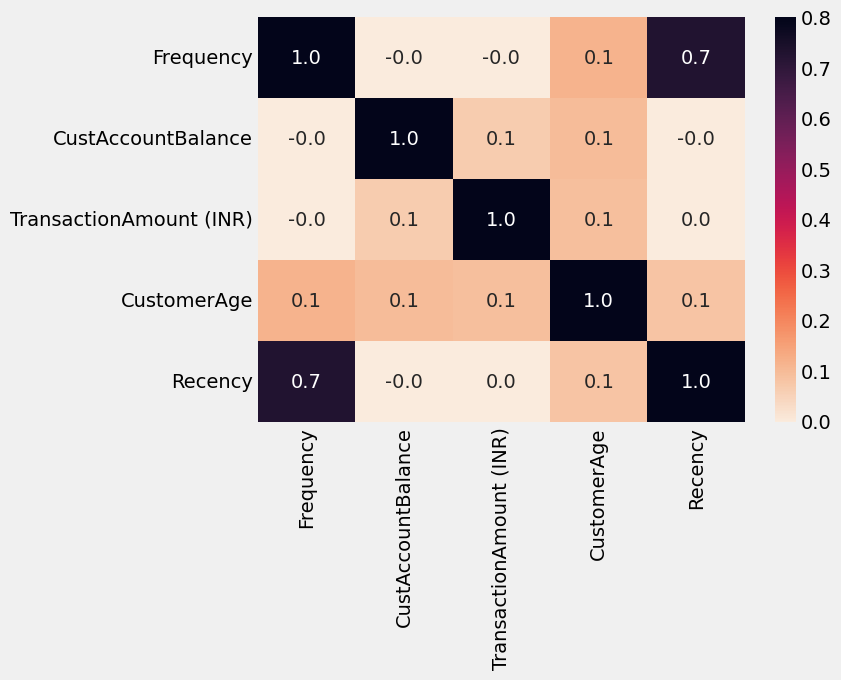

In [82]:
# correlation between features
plt.figure(figsize=(7,5))
correlation=RMF_data.corr()
sns.heatmap(correlation,vmin=None,
    vmax=0.8,
    cmap='rocket_r',
    annot=True,
    fmt='.1f',
    linecolor='white',
    cbar=True)

In [83]:
check(RMF_data)

column          dtypes  nunique  sum_null
0                Frequency           int64        6         0
1               CustGender          object        2         0
2             CustLocation          object     8544         0
3       CustAccountBalance         float64   253537         0
4  TransactionAmount (INR)         float64    98565         0
5              CustomerAge           int64       45         0
6         TransactionDate2  datetime64[ns]       55         0
7         TransactionDate1  datetime64[ns]       55         0
8          TransactionDate  datetime64[ns]      375         0
9                  Recency           int64      251         0

**Univariate, bivariate and multivariate analysis:**

In [84]:
#categorical variable
cat_data = RMF_data.iloc[:,[1,2]]
cat_data.head()

CustGender CustLocation
0          F        NOIDA
1          M       MUMBAI
2          F       MUMBAI
3          F    CHAMPARAN
4          F        DELHI

In [85]:
#numerical variable
num_data = RMF_data.iloc[:,[0,3,4,5,9]]
num_data.head()

Frequency  CustAccountBalance  TransactionAmount (INR)  CustomerAge  \
0          2           76340.635                   2553.0           33   
1          1           24204.490                   1499.0           22   
2          2          100112.950                    727.5           32   
3          1             496.180                     30.0           26   
4          1          296828.370                    557.0           28   

   Recency  
0       18  
1        1  
2      182  
3        1  
4        1

In [86]:
# Creating a map centered at a specific location (e.g., India)
m = folium.Map(location=[20.5937, 78.9629], zoom_start=5)

# Iterate through the unique 'CustLocation' values and add markers to the map
for location in cat_data['CustLocation'].unique():
    folium.Marker(
        location=[0, 0],
        popup=location,
    ).add_to(m)

# Display the map
m.save('location_map.html')

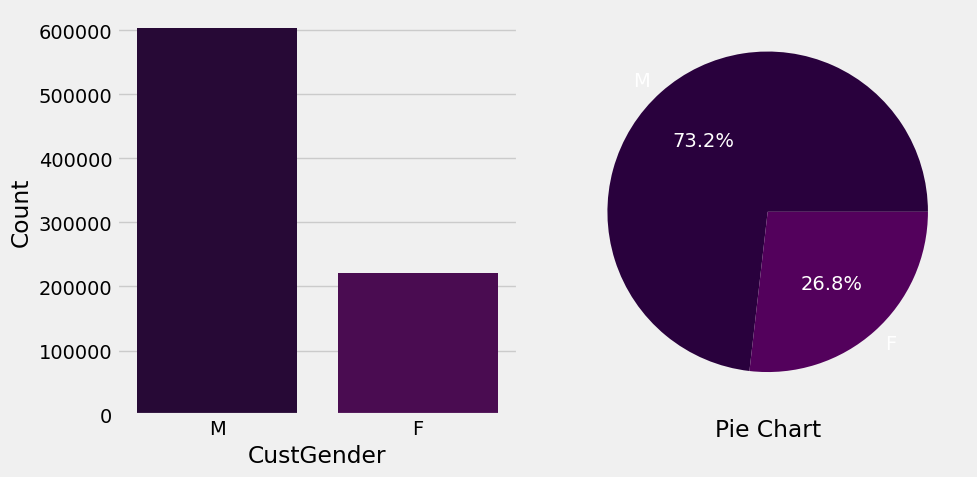

In [87]:
# Set the 'fivethirtyeight' style for the background color
plt.style.use("fivethirtyeight")

# Define the custom colors for the pie chart
custom_colors = ['#29013d', '#53015c']

# Create a figure with multiple subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot 1: Bar plot for 'CustGender' with custom colors
sns.barplot(x=cat_data['CustGender'].value_counts().index, y=cat_data['CustGender'].value_counts(), ax=axes[0],
palette=custom_colors)
axes[0].set_xlabel('CustGender')
axes[0].set_ylabel('Count')

# Plot 2: Pie chart for 'CustGender' with custom colors and white text
cat_data['CustGender'].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[1],
                                            colors=custom_colors, textprops={'color': 'white'})  # Use custom colors and white text
axes[1].set_xlabel('Pie Chart')  # Remove the y-label
axes[1].set_ylabel(' ')

# Display the plots
plt.tight_layout()
plt.show()

Inference: Male count seems to be aprox 50% higher than female.

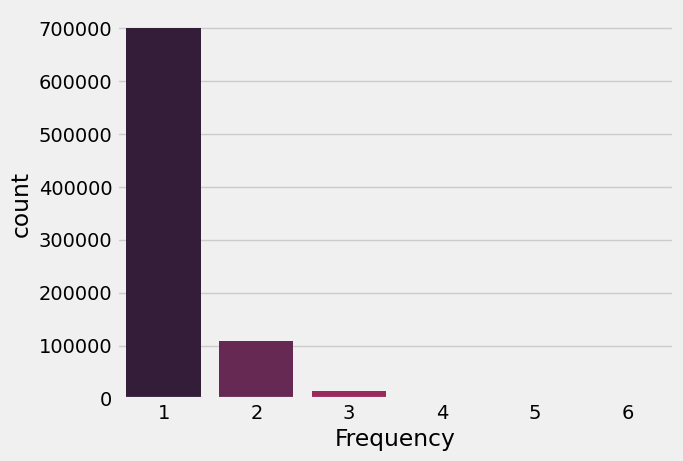

In [88]:
plt.style.use("fivethirtyeight")
chart=sns.countplot(x='Frequency',data=RMF_data,palette='rocket', order = RMF_data['Frequency'].value_counts().index)

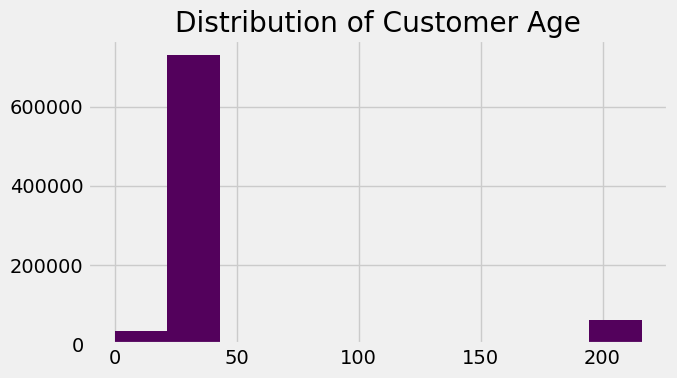

In [89]:
plt.style.use("fivethirtyeight")

fig, ax = plt.subplots(figsize=(7, 4))
palette_color = sns.color_palette('rocket')
ax.hist(x=RMF_data['CustomerAge'], color='#53015c')
ax.set_title("Distribution of Customer Age")

# Display the plot
plt.tight_layout()
plt.show()

In [90]:
RMF_data[RMF_data["CustomerAge"] > 50].shape

(59985, 10)

In [91]:
RMF_data.drop(RMF_data[RMF_data["CustomerAge"] > 50].index.tolist(), axis=0, inplace=True)
RMF_data.shape

(763700, 10)

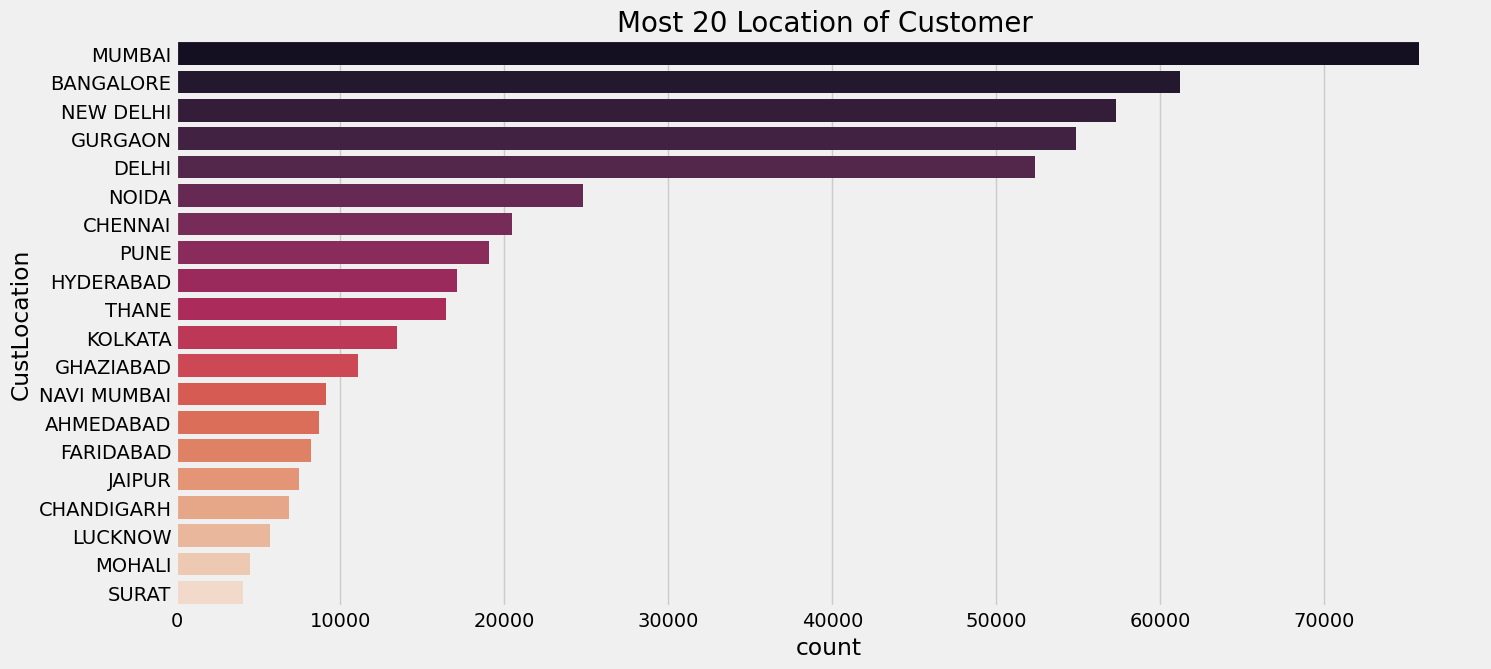

In [92]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15,7))
chart=sns.countplot(y='CustLocation',data=RMF_data,palette='rocket', order = RMF_data['CustLocation'].value_counts()[:20].index)
plt.title("Most 20 Location of Customer ",
          fontsize='20');

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


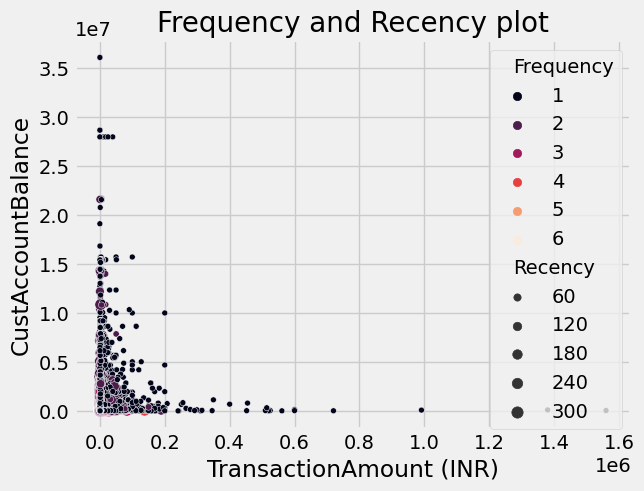

In [93]:
plt.style.use("fivethirtyeight")
sns.scatterplot(x='TransactionAmount (INR)',y='CustAccountBalance',data=RMF_data,palette='rocket',hue='Frequency',size='Recency' )
plt.title("Frequency and Recency plot",
          fontsize='20');

In [94]:
RMF_data.head()

Frequency CustGender CustLocation  CustAccountBalance  \
0          2          F        NOIDA           76340.635   
1          1          M       MUMBAI           24204.490   
2          2          F       MUMBAI          100112.950   
3          1          F    CHAMPARAN             496.180   
4          1          F        DELHI          296828.370   

   TransactionAmount (INR)  CustomerAge TransactionDate2 TransactionDate1  \
0                   2553.0           33       2016-09-26       2016-09-08   
1                   1499.0           22       2016-08-14       2016-08-14   
2                    727.5           32       2016-07-08       2016-01-08   
3                     30.0           26       2016-09-15       2016-09-15   
4                    557.0           28       2016-08-29       2016-08-29   

  TransactionDate  Recency  
0      2016-09-17       18  
1      2016-08-14        1  
2      2016-04-08      182  
3      2016-09-15        1  
4      2016-08-29        1

In [95]:
# difference between maximum and minimum date
RMF_data['TransactionDate'].max()-RMF_data['TransactionDate'].min()

Timedelta('336 days 00:00:00')

In [96]:
RMF_data=RMF_data.sort_values(by='TransactionDate')
groupbby_month=RMF_data.groupby([pd.Grouper(key='TransactionDate',freq='M')]).mean()
print(groupbby_month.shape)
groupbby_month

(12, 5)


<ipython-input-96-2429b4e93573>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  groupbby_month=RMF_data.groupby([pd.Grouper(key='TransactionDate',freq='M')]).mean()


Frequency  CustAccountBalance  TransactionAmount (INR)  \
TransactionDate                                                           
2016-01-31        1.021516        73693.347805              1236.190655   
2016-02-29        1.055400        74266.317605              1249.837640   
2016-03-31        1.079115        82245.500962              1378.467667   
2016-04-30        1.149173        80401.776759              1452.830364   
2016-05-31        1.319953        74524.772019              1343.227506   
2016-06-30        1.320765        77139.794628              1396.977180   
2016-07-31        1.315371        76398.778004              1309.693740   
2016-08-31        1.133036        86741.828711              1296.768886   
2016-09-30        1.185069        81972.567214              1240.236047   
2016-10-31        1.210932        77748.385293              1281.033173   
2016-11-30        1.049449        83653.114651              1311.489976   
2016-12-31        1.009830        73027.603930              1256.065965   

                 CustomerAge    Recency  
TransactionDate                          
2016-01-31         28.997420   1.701472  
2016-02-29         29.126066   4.424896  
2016-03-31         29.359299   7.521747  
2016-04-30         29.573792  22.123387  
2016-05-31         29.866018  56.750499  
2016-06-30         29.972778  48.108914  
2016-07-31         29.933395  32.981219  
2016-08-31         29.469461   6.395890  
2016-09-30         29.505058   9.371753  
2016-10-31         29.614344  17.354322  
2016-11-30         29.110086   3.327782  
2016-12-31         28.909523   1.303369

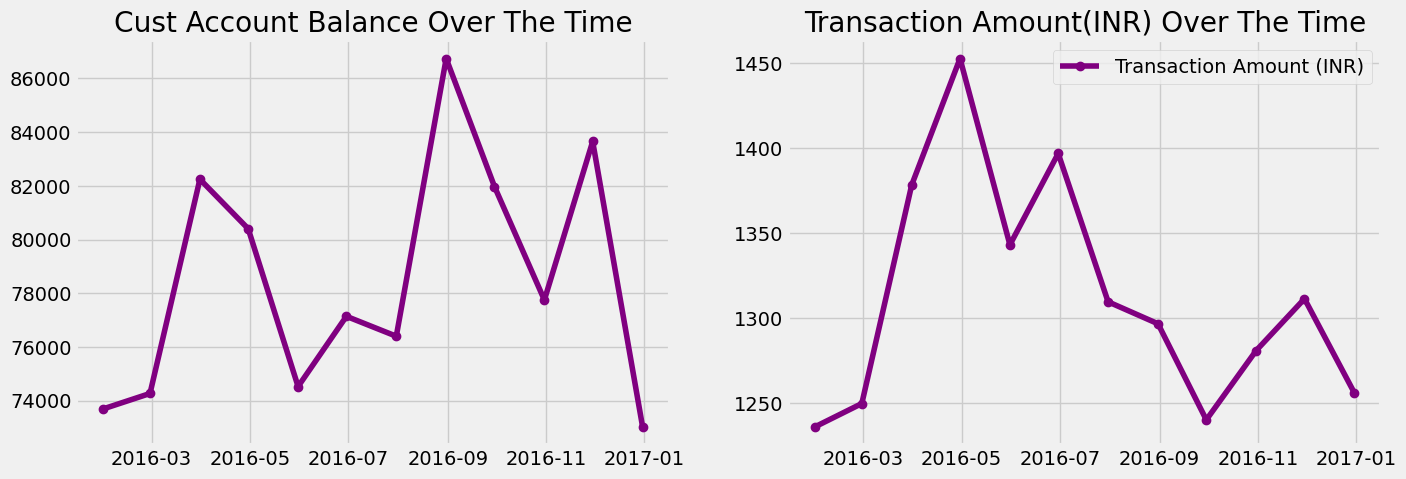

In [97]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(15,5))
ax[0].plot(groupbby_month.index,groupbby_month['CustAccountBalance'],color='purple',marker='o',label='Customer Account Balance')
ax[0].set_title('Cust Account Balance Over The Time')
ax[1].plot(groupbby_month.index,groupbby_month['TransactionAmount (INR)'],color='purple',marker='o',label='Transaction Amount (INR)')
ax[1].set_title("Transaction Amount(INR) Over The Time")
plt.legend()

# **Feature Engineering:**

In [98]:
# RMF_data.reset_index(drop=True, inplace = True)
# RMF_data.head()

In [99]:
RMF_data = RMF_data.drop(['TransactionDate1', 'TransactionDate2'], axis=1)
# RMF_data.head()

In [100]:
# RMF_data.drop(columns=['CustLocation','TransactionDate'],inplace=True)
RMF_data['CustGender']=RMF_data['CustGender'].map({'M':1,'F':0})
# print(RMF_data.shape)

In [101]:
RMF_data.head()

Frequency  CustGender CustLocation  CustAccountBalance  \
411948          1           1       MOHALI           373068.23   
350802          1           1       ROHTAK             9312.95   
100780          1           0      GURGAON            21152.14   
511987          1           1        DELHI            21781.23   
675485          1           1       MUMBAI           574138.77   

        TransactionAmount (INR)  CustomerAge TransactionDate  Recency  
411948                  2987.00           27      2016-01-08        1  
350802                  1008.63           30      2016-01-08        1  
100780                  2000.00           22      2016-01-08        1  
511987                   120.01           26      2016-01-08        1  
675485                   500.00           30      2016-01-08        1

In [102]:
minmax = MinMaxScaler()
standard_scaler = StandardScaler()
RMF_scaled = RMF_data.copy()
RMF_scaled[["Frequency", "CustGender","Recency"]] = minmax.fit_transform(RMF_data[["Frequency","CustGender", "Recency"]])
RMF_scaled[["CustAccountBalance", "TransactionAmount (INR)", "CustomerAge"]] = standard_scaler.fit_transform(RMF_data[["CustAccountBalance", "TransactionAmount (INR)", "CustomerAge"]])

In [103]:
# Assuming you have a DataFrame named 'data'
RMF_scaled = RMF_scaled[["Frequency", "CustGender", "CustAccountBalance", "TransactionAmount (INR)", "CustomerAge", "Recency"]]

**Feature Selection**: It selects specific columns from the DataFrame RMF_data for feature scaling. The selected columns are ["Frequency", "CustGender", "Recency"] for min-max scaling and ["CustAccountBalance", "TransactionAmount (INR)", "CustomerAge"] for standard scaling.

**Min-Max Scaling**: It applies min-max scaling to the columns ["Frequency", "CustGender", "Recency"]. Min-max scaling transforms the values of each selected column to a range between 0 and 1, preserving the relationships between values.

**Standard Scaling**: It applies standard scaling to the columns ["CustAccountBalance", "TransactionAmount (INR)", "CustomerAge"]. Standard scaling (z-score normalization) transforms the values of each selected column to have a mean of 0 and a standard deviation of 1.


# **Modelling:**

Sample Selection:

In [104]:
RMF_scaled=RMF_scaled.sample(n=75000,random_state=69).reset_index(drop=True)
RMF_scaled.head()

Frequency  CustGender  CustAccountBalance  TransactionAmount (INR)  \
0        0.0         1.0           -0.211076                -0.222273   
1        0.0         0.0            0.048845                 0.081343   
2        0.0         1.0           -0.047264                -0.121709   
3        0.0         1.0           -0.112382                 0.677308   
4        0.0         1.0           -0.212668                -0.188202   

   CustomerAge  Recency  
0    -0.984130      0.0  
1     0.270156      0.0  
2    -0.267395      0.0  
3     1.703625      0.0  
4     0.090972      0.0

In [105]:
wcss = []  # Store the WCSS values for different K
max_k = 10  # Adjust the maximum K value as needed

for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(RMF_scaled)
    wcss.append(kmeans.inertia_)  # WCSS for the current K

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

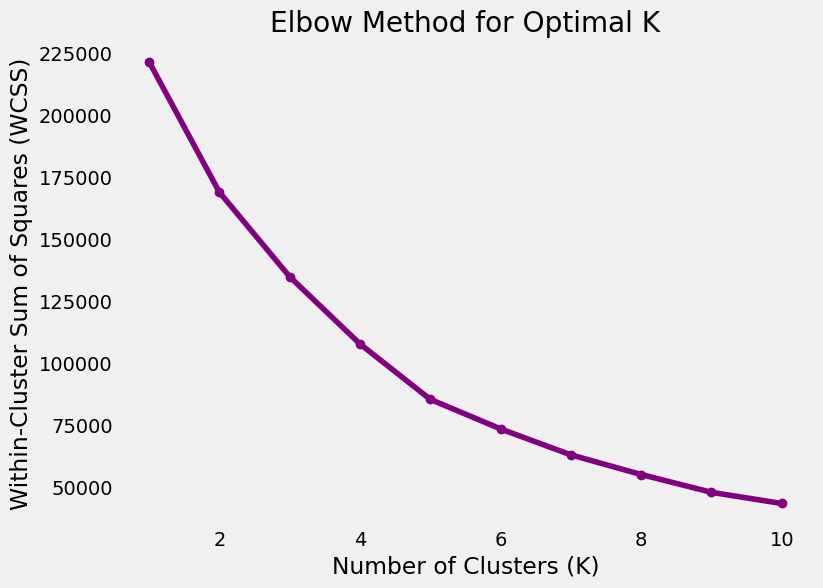

In [106]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 6))
plt.plot(range(1, max_k + 1), wcss,color='purple', marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal K')
plt.grid()
plt.show()

In [107]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(RMF_scaled)

# Silhouette Score
silhouette_avg = silhouette_score(RMF_scaled, kmeans.labels_)
print("Silhouette Score:", silhouette_avg)

# Davies-Bouldin Index
db_score = davies_bouldin_score(RMF_scaled, kmeans.labels_)
print("Davies-Bouldin Score:", db_score)

# For K-Means, calculate WCSS
wcss = kmeans.inertia_
print("Within-Cluster Sum of Squares (WCSS):", wcss)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.42316686279241783
Davies-Bouldin Score: 0.6654266092661636
Within-Cluster Sum of Squares (WCSS): 85286.36488021296


In [108]:
RMF_pca=PCA(n_components=3)
reduced_features=RMF_pca.fit_transform(RMF_scaled)
X_principal=pd.DataFrame(reduced_features)
X_principal.columns=['P1','P2', 'P3']

In [109]:
kmeans_set = {"init":"random", "max_iter":300, "random_state":42}
kmeans = KMeans(n_clusters=4 , **kmeans_set)
kmeans.fit(reduced_features)
X_principal['Label']=kmeans.labels_
X_principal.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


P1        P2        P3  Label
0 -0.949605  0.261321  0.247418      0
1  0.257573 -0.039412 -0.063758      2
2 -0.271842  0.008673  0.084771      2
3  1.595038 -0.198604 -0.911265      1
4 -0.092627 -0.208353 -0.199212      2

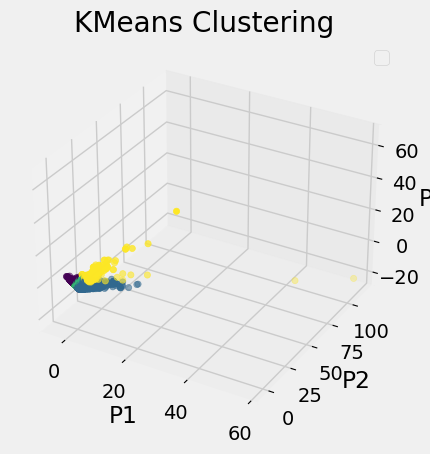

In [110]:
ax = plt.axes(projection='3d')
ax.scatter3D('P1','P2', 'P3', c = 'Label', data = X_principal, cmap='viridis',  linewidth=0.5)
#ax.scatter3D(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],kmeans.cluster_centers_[:,2], label='Cluster Centers')
ax.set_xlabel('P1')
ax.set_ylabel('P2')
ax.set_zlabel('P3')
plt.title('KMeans Clustering')
plt.legend()
plt.show()

In [111]:
attributes = RMF_scaled.columns[:6]
colors=['purple','yellow','red','blue','magenta']
cluster=['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5']

fig = go.Figure()
for index in range(0,5):
    fig.add_trace(go.Scatterpolar(r=np.mean(RMF_scaled.loc[X_principal.Label == index, attributes]),
                                  theta=attributes,
                                  fill='toself',
                                  fillcolor=colors[index],
                                  opacity=0.4,
                                  name=cluster[index]))

fig.update_layout(polar=dict(radialaxis=dict(visible=True)),showlegend=True,
                  title="Radar plot - Cluster attributes (Normalized Values)")
fig.show()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning:

In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning:

In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning:

In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning:

In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old

# **Result:**

Frequency	CustGender	CustAccountBalance	TransactionAmount (INR)	CustomerAge	Recency
0	0.0	1.0	-0.211076	-0.222273	-0.984130	0.0

In [114]:
# Install the required libraries
!pip install ipywidgets

import ipywidgets as widgets
from IPython.display import display

# Assuming you have already clustered your data and have labels
# Replace 'X_principal.Label' with the appropriate variable containing cluster labels

# Define a function to assign a cluster based on user input
def assign_cluster(Frequency, CustGender, CustAccountBalance, TransactionAmount, CustomerAge, Recency):
    data_point = np.array([[Frequency, CustGender, CustAccountBalance, TransactionAmount, CustomerAge, Recency]])
    reduced_point = pca.transform(data_point)  # Assuming 'pca' is the PCA model you used
    cluster = kmeans.predict(reduced_point)[0]  # Assuming 'kmeans' is your K-Means model
    return f"Data point belongs to Cluster {cluster + 1}"

# Load your PCA model and K-Means labels
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(RMF_scaled)

# Create input widgets for attributes
Frequency = widgets.FloatSlider(value=0.0, min=-1.0, max=1.0, description='Attribute 1:')
CustGender = widgets.FloatSlider(value=0.0, min=-1.0, max=1.0, description='Attribute 2:')
CustAccountBalance = widgets.FloatSlider(value=0.0, min=-1.0, max=1.0, description='Attribute 3:')
TransactionAmount = widgets.FloatSlider(value=0.0, min=-1.0, max=1.0, description='Attribute 4:')
CustomerAge = widgets.FloatSlider(value=0.0, min=-1.0, max=1.0, description='Attribute 5:')
Recency = widgets.FloatSlider(value=0.0, min=-1.0, max=1.0, description='Attribute 6:')

# Create a button for cluster assignment
assign_button = widgets.Button(description='Assign Cluster')

# Create an output widget to display the result
output = widgets.Output()

# Define a function to handle button click
def on_button_click(b):
    with output:
        cluster_result = assign_cluster(Frequency.value, CustGender.value, CustAccountBalance.value,
                                       TransactionAmount.value, CustomerAge.value, Recency.value)
        print(cluster_result)

assign_button.on_click(on_button_click)

# Display the widgets
display(Frequency, CustGender, CustAccountBalance, TransactionAmount, CustomerAge, Recency, assign_button, output)


FloatSlider(value=0.0, description='Attribute 1:', max=1.0, min=-1.0)

FloatSlider(value=0.0, description='Attribute 2:', max=1.0, min=-1.0)

FloatSlider(value=0.0, description='Attribute 3:', max=1.0, min=-1.0)

FloatSlider(value=0.0, description='Attribute 4:', max=1.0, min=-1.0)

FloatSlider(value=0.0, description='Attribute 5:', max=1.0, min=-1.0)

FloatSlider(value=0.0, description='Attribute 6:', max=1.0, min=-1.0)

Button(description='Assign Cluster', style=ButtonStyle())

Output()